<h1> Rappi Data Science Challenge - Part 3</h!>

<h2>Orders Data Analysis</h2>

Rappi’s Operations team is interested in predicting which orders are more likely to be
cancelled since they are not attractive enough for couriers. To solve this problem, we have
provided a sample of orders created in September 2017.
Your objective is to use this dataset to help Rappi understand what factors influence whether
an order is going to be taken by a courier, and offer recommendations to take actions based
on your insights to improve Rappi’s operation.

<h3>Task 1</h3>

In [6]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

First, we import the CSV file

In [7]:
csv_path = "orders.csv"
df = pd.read_csv(csv_path)
df.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1


Next, we count how many orders were taken and not taken:

In [8]:
df['taken'].value_counts()

1    135407
0     11580
Name: taken, dtype: int64

In total, 11580 orders were not taken, and 135407 were taken.

What day of the way has the highest number of non taken orders?

In [30]:
df["created_at"] =  pd.to_datetime(df["created_at"])

df['created_date'] = df['created_at'].dt.date
df['day_week'] = df['created_at'].dt.dayofweek

gk=df.groupby('taken')
dftemp = gk['day_week'].value_counts()
dftemp.columns = ['a', 'b', 'c']
dftemp

taken  day_week
0      5            2577
       4            1882
       1            1590
       3            1468
       6            1441
       0            1325
       2            1297
1      6           28298
       5           22258
       1           19530
       4           19360
       2           17358
       3           14911
       0           13692
Name: day_week, dtype: int64

In [36]:
print("Monday: " + str((dftemp.loc[0][0]*100) / (dftemp.loc[0][0] + dftemp.loc[1][0])) + "%")
print("Tuesday: " + str((dftemp.loc[0][1]*100) / (dftemp.loc[0][1] + dftemp.loc[1][1])) + "%")
print("Wednesday: " + str((dftemp.loc[0][2]*100) / (dftemp.loc[0][2] + dftemp.loc[1][2])) + "%")
print("Thursday: " + str((dftemp.loc[0][3]*100) / (dftemp.loc[0][3] + dftemp.loc[1][3])) + "%")
print("Friday: " + str((dftemp.loc[0][4]*100) / (dftemp.loc[0][4] + dftemp.loc[1][4])) + "%")
print("Saturday: " + str((dftemp.loc[0][5]*100) / (dftemp.loc[0][5] + dftemp.loc[1][5])) + "%")
print("Sunday: " + str((dftemp.loc[0][6]*100) / (dftemp.loc[0][6] + dftemp.loc[1][6])) + "%")

Monday: 8.82333355530399%
Tuesday: 7.528409090909091%
Wednesday: 6.952559635486465%
Thursday: 8.962696135295195%
Friday: 8.859806044628566%
Saturday: 10.376484799677874%
Sunday: 4.845489088402434%


<b>The day of the week with the highest percentage of non taken orders is Saturday (5) with 10.38%.</b>

<h3>Task 2</h3>

Next, we describe the dataframe, to get statistical information. Not really necessary for this case, but interesting. nonetheless

In [105]:
df.describe(include="all")

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,created_date,day_week
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987,146987.000000,146987,146987.000000
unique,NaN,NaN,NaN,NaN,NaN,26914,NaN,30,NaN
top,NaN,NaN,NaN,NaN,NaN,2017-09-23 19:06:05+00:00,NaN,2017-09-24,NaN
freq,NaN,NaN,NaN,NaN,NaN,59,NaN,7908,NaN
first,NaN,NaN,NaN,NaN,NaN,2017-09-05 00:01:02+00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-10-04 23:58:53+00:00,NaN,NaN,NaN
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,NaN,0.921218,NaN,3.368624
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,NaN,0.269400,NaN,2.031396
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,NaN,0.000000,NaN,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,NaN,1.000000,NaN,2.000000


In [106]:
df.shape

(146987, 9)

Now we are going to plot the data, to see if we can find any correlation to "taken". We will take total_earning, to_user_distance and day_week as they are the most likely variables to have any effect on "taken".

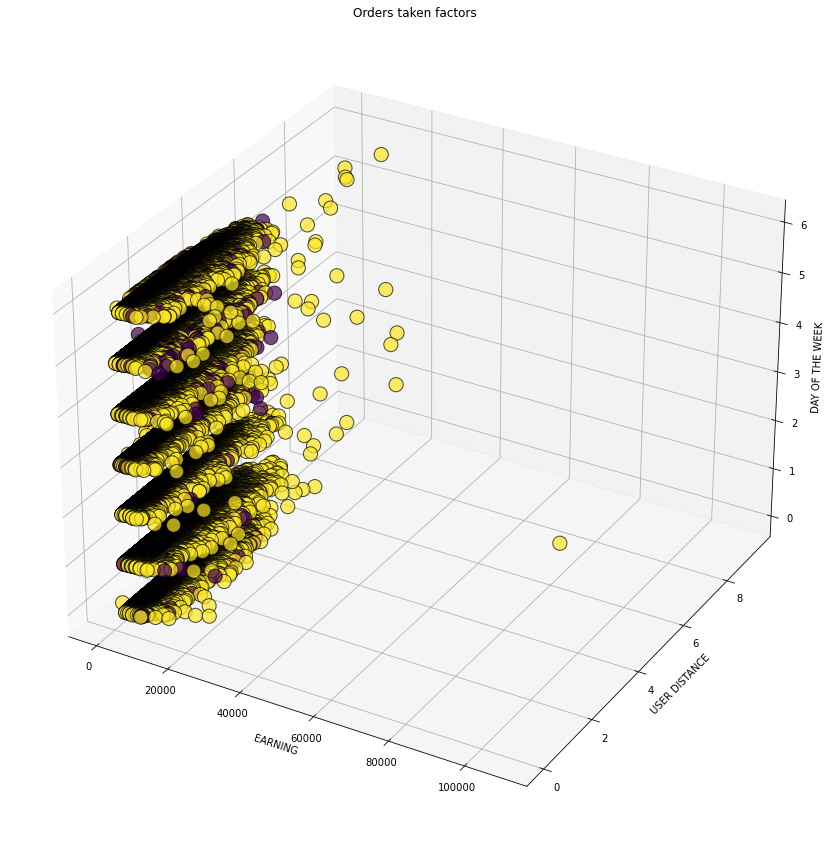

In [107]:
from mpl_toolkits.mplot3d import Axes3D

x = df["total_earning"]
y = df["to_user_distance"]
z = df["day_week"]
c = df["taken"]
color = ['taken:0', 'taken:1']

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=c)
plt.title("Orders taken factors")
ax.set_xlabel('EARNING')
ax.set_ylabel('USER DISTANCE')
ax.set_zlabel('DAY OF THE WEEK')

plt.show()

From this plot, we can appreciate that among those 3 variables, earning seems to be the most important one when trying to predict if an order is going to be taken or not. Day of the week seems to be a close 2nd.
<br>
We will now apply the k-nearest neighbor algorithm to build our model. We chose this algorith as it seems well suited for predicting the dependent variable Y "taken" from the dependent variables X . For this we will build a classifier.
<br>
First we create a numpy array, each for X and Y:

In [108]:
X = df[['to_user_distance', 'day_week', 'total_earning', 'taken']].values  

In [109]:
y = df['taken'].values

Since KNN is based on the distance to points, it's a good idea to standarize our data:

In [110]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.15525699, -0.18146424, -0.65099725, -3.4195289 ],
       [-1.24064589, -0.18146424, -0.65099725, -3.4195289 ],
       [ 0.6208006 , -0.18146424, -0.76336975, -3.4195289 ],
       [ 1.383842  , -0.18146424, -0.53862476,  0.29243794],
       [-0.63317153, -0.18146424, -1.07239412,  0.29243794]])

Now we will make a Test/Train split of our dataset.

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Training set:', X_train.shape,  y_train.shape)
print ('Testing set:', X_test.shape,  y_test.shape)

Training set: (117589, 4) (117589,)
Testing set: (29398, 4) (29398,)


Now we will train our model with the the training data set. We start using a number of neighbors, K, of 1:

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
k = 1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

And now we will use our testing set on the model, and check the results of "taken" for the first ten registries:

In [114]:
yhat = neigh.predict(X_test)
yhat[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [115]:
unique, counts = np.unique(yhat, return_counts=True)
dict(zip(unique, counts))

{0: 2297, 1: 27101}

Now we will validate the accuracy of our model, with the training and testing sets:

In [116]:
from sklearn import metrics
print("Training set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Testing set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Training set Accuracy:  1.0
Testing set Accuracy:  1.0


From this, we can see that we have an extremely high accuracy in both our sets using this algorithm with K=1.
<br>
Just in case, let's validate our accuracy with other K values, going from 1 to 10:

In [72]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([1.        , 1.        , 0.99996598, 0.99996598, 0.99996598,
       1.        , 0.99996598, 0.99996598, 0.99993197])

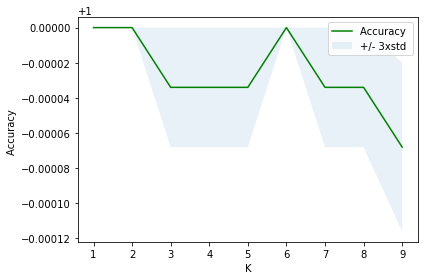

In [73]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('K')
plt.tight_layout()
plt.show()

In [53]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 1.0 with k= 1


As we can see, with either K=1 or K=2, the accuracy is very good, no need to to use more neighbors.

<h4>Conclusions</h4>

At first, I thought and tried using LogisticRegression, due to the nature of Y being a binary value, however, after several tries, I was not able to get valid predictive values. 
<br>
Even though the corrrelation factor of "taken" with "total_earning", "to_user_distance" and "day _week" was very low in that algorithm, using a k-nearest algorith presented a clearer relationship between X and Y variables. Especially with "total_earning".
<br>


<h3>Task 3</h3>

Rappi can take advantage of these insights by noticing that the more a courier is going to earn, the more likely he is to take an order. It does sound logical, but here we can see that's the case.
<br>
Also, the day of the week seems to have an impact too, altough a lower one. This can be explained by the fact that the weekend is clearly the busiest, and so couriers try to pick and choose the orders with the highest earnings and ignore the other ones.
<br>
To increase the number of orders taken by couriers to offset this, specially on weekends, I can think of implmenting a kind of bonus that grows the more orders are taken by a specific courier. The more orders they take, specially on Saturdays, the bigger the bonus they get.